In [1]:
import numpy as np
import PIL
import matplotlib.pyplot as plt
#import torch
#import openpifpaf
import cv2
import os
import pandas as pd
#import ultralytics
#from ultralytics import YOLO
import photoshop.api as ps
import shutil

#ultralytics.checks()

In [ ]:
#print('OpenPifPaf version', openpifpaf.__version__)
#print('PyTorch version', torch.__version__)

OpenPifPaf version 0.13.11
PyTorch version 1.13.1+cpu


In [5]:
ds_path = "C:/Users/Austin Paulraj/Desktop/Austin/Dataset/Characters"
extract_path = "C:/Users/Austin Paulraj/Desktop/Austin/Dataset/test"


In [6]:
def collect_data(ds_path, extract_path):
    ds = {"path":[], "content_source":[],"character":[],"art_type":[],"filename":[],"image_name":[]}
    trim_extract_ds = {"folder_name":[], "frame":[], "angle":[], "image_name":[]}
    extract_count = 0
    processed_count = 0
    for source in os.listdir(ds_path):
        #print(source)
        source_path = os.path.join(ds_path,source)
        
        for character in os.listdir(source_path):
            #print(character)
            character_path = os.path.join(source_path,character)
            
            ds["path"].append(character_path)
            file_aux = []
            img_aux = []
            for art_type in os.listdir(character_path):
                #print(art_type)
                if art_type == "Concept_Art":
                    art_path = os.path.join(character_path,art_type)
                    
                    
                    

                    for image_filename in os.listdir(art_path):
                        file_aux.append(os.path.join(art_type,image_filename))
                        img_aux.append(image_filename)

                        extract_folder = os.path.join(extract_path, image_filename)

                        if os.path.exists(extract_folder):
                            trim_extract_ds["image_name"].append(image_filename)
                            processed_count = processed_count+1
                            f_name_aux = []
                            frame_aux = []
                            ang_aux = []                                                                  
                            if os.path.exists(os.path.join(extract_folder,"Extracted_images")):
                                for trim_extract in os.listdir(os.path.join(extract_folder,"Extracted_images")):
                                    extract_count = extract_count + 1
                                    f_name_aux.append(trim_extract)
                                    if "fa" in trim_extract.split("_")[1]:
                                        frame_aux.append("face")
                                    elif "fu" in trim_extract.split("_")[1]:
                                        frame_aux.append("full")
                                    elif "ha" in trim_extract.split("_")[1]:
                                        frame_aux.append("half")
                                    else:
                                        frame_aux.append("redo")

                                    if "fr" in trim_extract.split("_")[2]:
                                        ang_aux.append("front")
                                    elif "ba" in trim_extract.split("_")[2]:
                                        ang_aux.append("back")
                                    elif "th" in trim_extract.split("_")[2]:
                                        ang_aux.append("third")
                                    elif "si" in trim_extract.split("_")[2]:
                                        ang_aux.append("side")
                                    else:
                                        ang_aux.append("redo")
                                trim_extract_ds["frame"].append(frame_aux)
                                trim_extract_ds["angle"].append(ang_aux)
                                trim_extract_ds["folder_name"].append(f_name_aux)                                
                                    

                    
                    ds["art_type"].append(art_type)

                
            ds["filename"].append(file_aux)
            ds["image_name"].append(img_aux)
            ds["content_source"].append(source)
            ds["character"].append(character)

    print(extract_count)
    print(processed_count)

    return ds, trim_extract_ds

In [7]:
ds, extract_ds = collect_data(ds_path, extract_path)


87
24


In [8]:
n = 5

#    ds = {"path":[], "content_source":[],"character":[],"art_type":[],"filename":[],"image_name":[]}

print(ds["path"][n])
print(ds["filename"][n])
print(ds["image_name"][n])
print(len(ds["image_name"][n]))
print(ds["art_type"][n])
print(ds["content_source"][n])
print(ds["character"][n])
print(len(ds["path"]))
print(len(ds["filename"]))
print(len(ds["image_name"]))

C:/Users/Austin Paulraj/Desktop/Austin/Dataset/Characters\Pokemon\Acerola
['Concept_Art\\6d3dc0f8c1ec8141f434d6c50f421ebe.jpg', 'Concept_Art\\7d81429829a8dd59c18a0ed21234a25c.jpg']
['6d3dc0f8c1ec8141f434d6c50f421ebe.jpg', '7d81429829a8dd59c18a0ed21234a25c.jpg']
2
Concept_Art
Pokemon
Acerola
33
33
33


In [9]:
#trim_extract_ds = {"folder_name":[], "frame":[], "angle":[], "image_name":[]}

print(extract_ds["folder_name"][n])
print(len(extract_ds["folder_name"][n]))
print(extract_ds["frame"][n])
print(extract_ds["angle"][n])
print(extract_ds["image_name"][n])
print(len(extract_ds["folder_name"]))
print(len(extract_ds["frame"]))
print(len(extract_ds["angle"]))
print(len(extract_ds["image_name"]))

['0_face_front', '1_face_third', '2_full_third', '3_full_front', '4_full_back', '5_half_front', '6_half_back']
7
['face', 'face', 'full', 'full', 'full', 'half', 'half']
['front', 'third', 'third', 'front', 'back', 'front', 'back']
e830b559d2130f5028d84b3db5272d57.jpg
24
24
24
24


In [10]:
def find_first_color_pix(img): 
    i = 0
    j = 0
    for row in img:
        i=i+1
        j=0
        for pix in row:
            j=j+1
            if np.mean(pix) != 255:
                return np.array([j,i])

def find_bounding_box(trim, full):
    x = find_first_color_pix(trim)
    y = find_first_color_pix(full)
    coords = [y-x, y-x+np.flip(trim.shape[0:2])]

    return np.array(coords)

In [11]:
finetune_ds = {"images":[], "coord_lines":[]}
for n in range(len(extract_ds["image_name"])):
    path_aux = os.path.join(extract_path, extract_ds["image_name"][n])
    target_paths = [os.path.join(path_aux, "Full_image"), os.path.join(path_aux, "Extracted_image")]
    full_path = os.path.join(path_aux, "Full_images")
    trim_path = os.path.join(path_aux, "Extracted_images")
    full_path_aux = full_path

    print(extract_ds["frame"][n])
    finetune_ds["images"].append(os.path.join(full_path,"original_image.png"))

    frame_i = -1
    coord_aux = []
    for x in os.listdir(full_path_aux):
        frame_i = frame_i + 1
        full_path = os.path.join(path_aux, "Full_images")
        trim_path = os.path.join(path_aux, "Extracted_images")
        y = os.path.join(full_path_aux,x)
        if os.path.isdir(y):

            full_path = os.path.join(full_path, y)
            trim_path = os.path.join(trim_path, x)

            full_path = os.path.join(full_path, "bg_removed_image.png")
            trim_path = os.path.join(trim_path, "bg_removed_image.png")

            full_img = np.array(PIL.Image.open(full_path).convert('RGB'))
            trim_img = np.array(PIL.Image.open(trim_path).convert('RGB'))

            out = find_bounding_box(trim_img,full_img)
            
            if extract_ds["frame"][n][frame_i] == "full" or extract_ds["frame"][n][frame_i] == "redo":
                cat = 0
            elif extract_ds["frame"][n][frame_i] == "half":
                cat = 1
            elif extract_ds["frame"][n][frame_i] == "face":
                cat = 2
                
            center_x = (out[0][0]+out[1][0])/2.0
            center_y = (out[0][1]+out[1][1])/2.0
            width = center_x - out[0][0] 
            height = center_y - out[0][1] 

            center_x = center_x/float(full_img.shape[0])
            height = height/float(full_img.shape[0])
            center_y = center_y/float(full_img.shape[1])
            width = width/float(full_img.shape[1])

            out_str = str(0) + " "+str(center_x)+" "+str(center_y)+" "+str(width)+" "+str(height)
            coord_aux.append(out_str)
            print(coord_aux)
        
    finetune_ds["coord_lines"].append(coord_aux)
            

        
    

['full', 'face', 'face', 'face', 'full']
['0 0.19314641744548286 0.8491228070175438 0.11403508771929824 0.21495327102803738']
['0 0.19314641744548286 0.8491228070175438 0.11403508771929824 0.21495327102803738', '0 0.3855140186915888 0.6701754385964912 0.10614035087719298 0.09034267912772585']
['0 0.19314641744548286 0.8491228070175438 0.11403508771929824 0.21495327102803738', '0 0.3855140186915888 0.6701754385964912 0.10614035087719298 0.09034267912772585', '0 0.5786604361370716 0.7289473684210527 0.07631578947368421 0.10358255451713395']
['0 0.19314641744548286 0.8491228070175438 0.11403508771929824 0.21495327102803738', '0 0.3855140186915888 0.6701754385964912 0.10614035087719298 0.09034267912772585', '0 0.5786604361370716 0.7289473684210527 0.07631578947368421 0.10358255451713395', '0 0.5817757009345794 0.9833333333333333 0.10789473684210527 0.11137071651090343']
['0 0.19314641744548286 0.8491228070175438 0.11403508771929824 0.21495327102803738', '0 0.3855140186915888 0.670175438596

In [12]:
n=-1
for i in finetune_ds["images"]:
    n=n+1
    shutil.copyfile(i, os.path.join("C:/Austin/Projects/MS_Thesis/finetune/images",i.split("\\")[1]))
    with open(os.path.join("C:/Austin/Projects/MS_Thesis/finetune/labels",i.split("\\")[1].split(".")[0]+".txt"), "w") as file:
        for ex in finetune_ds["coord_lines"][n]:
            file.write(ex + "\n")

In [83]:
print(out)
center_x = (out[0][0]+out[1][0])/2.0
print(center_x)

center_y = (out[0][1]+out[1][1])/2.0
print(center_y)
width = center_x - out[0][0] 
print(width)

height = center_y - out[0][1] 
print(height)

center_x = center_x/float(full_img.shape[0])
height = height/float(full_img.shape[0])
center_y = center_y/float(full_img.shape[1])
width = width/float(full_img.shape[1])

out_str = str(cat) + " "+str(center_x)+" "+str(center_y)+" "+str(width)+" "+str(height)
print(out_str)

[[456  66]
 [706 517]]
581.0
291.5
125.0
225.5
0 1.0525362318840579 0.39659863945578233 0.17006802721088435 0.40851449275362317


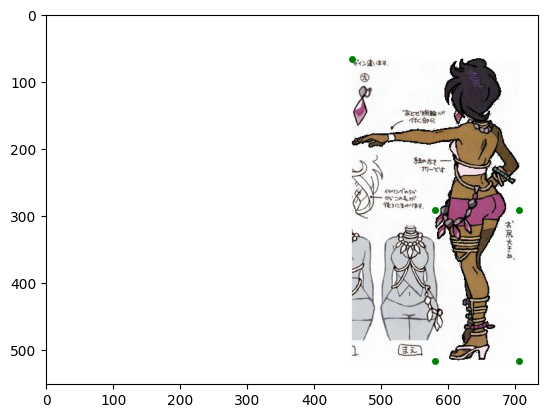

In [84]:
plt.imshow(full_img)
plt.plot([456,706,581, 581+125,581], [66,517,291.5, 291.5,291.5+225.5], "og", markersize=4)
plt.show()

In [58]:
trim_img.shape

(422, 95, 3)

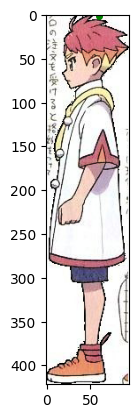

In [59]:
plt.imshow(trim_img)
plt.plot(60,1, "og", markersize=4)
plt.show()

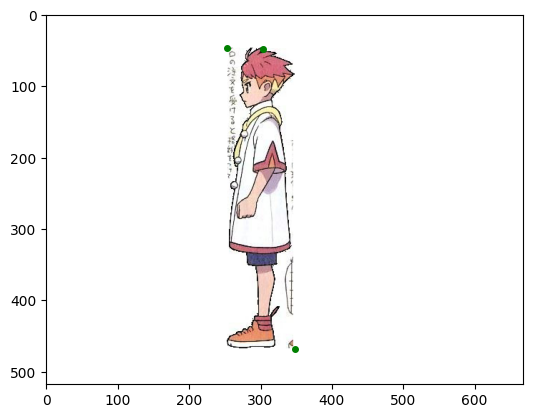

In [61]:
plt.imshow(full_img)
plt.plot(x, y, "og", markersize=4)
plt.show()